### Neural Net with TensorFlow

In [ ]:
# Install tensorflow and protobuf -- run once!
# anaconda install instructions: https://www.tensorflow.org/install/install_mac

# # For chase's macbook, the following shell commands worked (take out ! if in terminal)
# !conda create -n tensorflow python=2.7
# !source activate tensorflow
# !pip install --ignore-installed --upgrade https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.4.0-py2-none-any.whl

# Remember to activate container when you want to use package

In [29]:
import sys, csv, json
import requests
import numpy as np
import pandas as pd
import csv, json
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

In [97]:
# Import Dataset Pickle
import pickle
import pandas as pd
dfNN_raw = pickle.load(open('NN_pickles.p', 'rb'))
print dfNN_raw.head(5)
# pd.options.display.max_rows = len(dfNN_raw)
# dfNN_raw.head(len(dfNN_raw))


  prev_price compound    neg    neu   pos next_price
0     307.15   0.7424      0   0.69  0.31     307.26
1        463  -0.7003  0.209  0.791     0     467.29
2     465.01  -0.1759  0.253  0.747     0     461.57
3     464.53        0      0      1     0     465.01
4        462        0      0      1     0        465


In [98]:
# Python
# import tensorflow as tf
# hello = tf.constant('Hello, TensorFlow!')
# sess = tf.Session()
# print(sess.run(hello))

In [99]:
dfNN = (dfNN_raw - dfNN_raw.mean()) / (dfNN_raw.max() - dfNN_raw.min())
dfNN.reset_index(inplace=True)
del dfNN['index']
dfNN['next_price'] = dfNN['prev_price'].shift(-1)
dfNN.head(5)
print dfNN.head(5), type(dfNN)

  prev_price   compound       neg       neu       pos next_price
0  -0.205992   0.342107 -0.041533 -0.237517   0.30568   0.468625
1   0.468625   -0.46241  0.214909  -0.11359 -0.110987   0.477325
2   0.477325   -0.16998  0.268896 -0.167578 -0.110987   0.475247
3   0.475247 -0.0718898 -0.041533  0.142851 -0.110987   0.464296
4   0.464296 -0.0718898 -0.041533  0.142851 -0.110987   0.477325 <class 'pandas.core.frame.DataFrame'>


In [100]:
dfNN = pd.DataFrame(dfNN)
dfNN = dfNN.dropna()

In [101]:
# Taking straight from LSTM Stock Model
num_epochs = 1000

batch_size = 1

total_series_length = len(dfNN.index)

truncated_backprop_length = 3 #The size of the sequence

state_size = 12 #The number of neurons

num_features = 4
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 6426
The current configuration gives us 2142 batches of 1 observations each one looking 3 steps in the past


In [102]:
# Split Training-Test
dfTrain = dfNN[dfNN.index < num_batches*batch_size*truncated_backprop_length]
print dfTrain

for i in range(min_test_size,len(dfNN.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(dfNN.index)-i
        break

dfTest =  dfNN[dfNN.index >= test_first_idx]

     prev_price   compound        neg         neu          pos next_price
0     -0.205992   0.342107  -0.041533   -0.237517      0.30568   0.468625
1      0.468625   -0.46241   0.214909    -0.11359    -0.110987   0.477325
2      0.477325   -0.16998   0.268896   -0.167578    -0.110987   0.475247
3      0.475247 -0.0718898  -0.041533    0.142851    -0.110987   0.464296
4      0.464296 -0.0718898  -0.041533    0.142851    -0.110987   0.477325
5      0.477325 -0.0146195  -0.041533    -0.17494     0.237131   0.472953
6      0.472953 -0.0146195   0.203866   -0.368805      0.18068   0.462435
7      0.462435 -0.0718898  -0.041533    0.142851    -0.110987   0.472953
8      0.472953 -0.0718898  -0.041533    0.142851    -0.110987   0.472953
9      0.472953   0.212845  -0.041533   0.0115631    0.0328301   0.457197
10     0.457197 -0.0718898  -0.041533    0.142851    -0.110987   0.457197
11     0.457197 -0.0718898  -0.041533    0.142851    -0.110987   0.531216
12     0.531216   0.152228  -0.041533 

In [103]:
xTrain = dfTrain[['prev_price','neu','neg','pos']].as_matrix()[::-1]
yTrain = dfTrain['next_price'].as_matrix()[::-1]

print xTrain
print yTrain
# xTrain = dfTrain[['prev_price','neu','neg','pos']]
# yTrain = dfTrain['next_price']

[[-0.21741998280605976 0.14285147884497984 -0.04153298939890261
  -0.11098711498210005]
 [-0.21741998280605976 0.012176632219212913 -0.04153298939890261
  0.03215804630822253]
 [-0.21741998280605976 0.001133687433936965 -0.04153298939890261
  0.04425482050177093]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.21490872839250844
  -0.11098711498210005]
 [-0.20599240077852973 -0.23751661931452944 -0.04153298939890261
  0.3056795516845666]]
[-0.21741998280605976 -0.21741998280605976 -0.21741998280605976 ...,
 0.47524731872627507 0.47732506091309879 0.46862451550577483]


In [104]:
xTrain.shape


(6416, 4)

In [105]:
xTest = dfTest[['prev_price','neu','neg','pos']].as_matrix()
yTest = dfTest['next_price'].as_matrix()

In [106]:
yTest.shape


(112,)

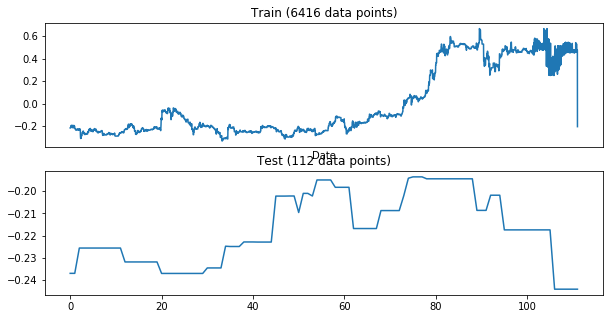

In [107]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig,ax = plt.subplots(2,1, figsize = (10,5))
ax[0].plot(xTrain[:,0])
ax[0].set_title('Train (' +str(len(xTrain))+' data points)')
ax[0].set_xlabel('Date')
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%y'))

ax[1].plot(xTest[:,0])
ax[1].set_title('Test (' +str(len(xTest))+' data points)')

# plt.figure(figsize=(25,5))
# plt.plot(xTrain[:,0])
# plt.title('Train (' +str(len(xTrain))+' data points)')
# plt.xaxis.set_major_locator(mdates.MonthLocator())
# plt.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%y'))

plt.show()

# plt.figure(figsize=(10,3))
# plt.plot(xTest[:,0])
# plt.title('Test (' +str(len(xTest))+' data points)')
# plt.show()

In [108]:
# LOAD DATA^

In [109]:
# SETUP NET

In [110]:
tf.reset_default_graph()


In [111]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

In [112]:
# irrelevant if no more classes (random array unif distribution) 
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

In [113]:
# unpack and create edge from input to hidden layer
labels_series = tf.unstack(batchY_placeholder, axis=1)


In [114]:
# forward pass
cell = tf.contrib.rnn.BasicLSTMCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

In [115]:
# talk about permutations and how data goes through nodes
states_series = tf.transpose(states_series,[1,0,2])


In [116]:
# backwards pass starting point
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

In [117]:
# bp weights and biases
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

In [118]:
prediction = tf.matmul(last_state,weight) + bias
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))
train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)


In [69]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    num_epochs = 50
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            try:
                batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
                batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
            except:
                print xTrain, start_idx, end_idx, batch_size, truncated_backprop_length, num_features
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
#             if type(loss) != float(1):
#                 print _loss,_train_step,_pred,_last_label,_prediction
            
           
            
            if(batch_idx % 50 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest) - truncated_backprop_length):
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][0]) #The last one
        

Epoch 0
Step 0 - Loss: 0.065730
Step 50 - Loss: 0.000025
Step 100 - Loss: 0.000057
Step 150 - Loss: 0.000007
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000011
Step 300 - Loss: 0.000033
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000018
Step 450 - Loss: 0.000090
Step 500 - Loss: 0.000041
Step 550 - Loss: 0.000161
Step 600 - Loss: 0.000005
Step 650 - Loss: 0.000128
Step 700 - Loss: 0.000052
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000009
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000151
Step 1000 - Loss: 0.000064
Step 1050 - Loss: 0.000387
Step 1100 - Loss: 0.000417
Step 1150 - Loss: 0.000010
Step 1200 - Loss: 0.000001
Step 1250 - Loss: 0.000014
Step 1300 - Loss: 0.000015
Step 1350 - Loss: 0.000069
Step 1400 - Loss: 0.000049
Step 1450 - Loss: 0.000596
Step 1500 - Loss: 0.000364
Step 1550 - Loss: 0.001512
Step 1600 - Loss: 0.000000
Step 1650 - Loss: 0.000006
Step 1700 - Loss: 0.000045
Step 1750 - Loss: 0.000246
Step 1800 - Loss: 0.000000
Step 1850 - Loss

Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000011
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000000
Step 450 - Loss: 0.000008
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000002
Step 600 - Loss: 0.000002
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000006
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000000
Step 900 - Loss: 0.000000
Step 950 - Loss: 0.000004
Step 1000 - Loss: 0.000009
Step 1050 - Loss: 0.000000
Step 1100 - Loss: 0.000001
Step 1150 - Loss: 0.000007
Step 1200 - Loss: 0.000018
Step 1250 - Loss: 0.000001
Step 1300 - Loss: 0.000000
Step 1350 - Loss: 0.000002
Step 1400 - Loss: 0.000014
Step 1450 - Loss: 0.000035
Step 1500 - Loss: 0.000003
Step 1550 - Loss: 0.000012
Step 1600 - Loss: 0.000000
Step 1650 - Loss: 0.000002
Step 1700 - Loss: 0.000011
Step 1750 - Loss: 0.000123
Step 1800 - Loss: 0.000011
Step 1850 - Loss: 0.000000
Step 1900 - Loss: 0.000002
Step 1950 - Loss: 0.000002
Step 2000 - Loss: 

Step 100 - Loss: 0.000002
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000014
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000024
Step 450 - Loss: 0.000000
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000002
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000010
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000001
Step 900 - Loss: 0.000000
Step 950 - Loss: 0.000000
Step 1000 - Loss: 0.000023
Step 1050 - Loss: 0.000001
Step 1100 - Loss: 0.000002
Step 1150 - Loss: 0.000008
Step 1200 - Loss: 0.000029
Step 1250 - Loss: 0.000009
Step 1300 - Loss: 0.000001
Step 1350 - Loss: 0.000002
Step 1400 - Loss: 0.000024
Step 1450 - Loss: 0.000018
Step 1500 - Loss: 0.000012
Step 1550 - Loss: 0.000016
Step 1600 - Loss: 0.000001
Step 1650 - Loss: 0.000004
Step 1700 - Loss: 0.000002
Step 1750 - Loss: 0.000114
Step 1800 - Loss: 0.000004
Step 1850 - Loss: 0.000003
Step 1900 - Loss: 0.000006
Step 1950 - Loss: 0

Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000000
Step 350 - Loss: 0.000001
Step 400 - Loss: 0.000006
Step 450 - Loss: 0.000002
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000007
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000009
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000001
Step 900 - Loss: 0.000000
Step 950 - Loss: 0.000007
Step 1000 - Loss: 0.000006
Step 1050 - Loss: 0.000001
Step 1100 - Loss: 0.000000
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000000
Step 1250 - Loss: 0.000015
Step 1300 - Loss: 0.000006
Step 1350 - Loss: 0.000000
Step 1400 - Loss: 0.000003
Step 1450 - Loss: 0.000023
Step 1500 - Loss: 0.000000
Step 1550 - Loss: 0.000085
Step 1600 - Loss: 0.000046
Step 1650 - Loss: 0.000008
Step 1700 - Loss: 0.000001
Step 1750 - Loss: 0.000019
Step 1800 - Loss: 0.000000
Step 1850 - Loss: 0.000056
Step 1900 - Loss: 0.000022
Step 1950 - Loss: 0.000009
Step 2000 - Loss: 

  0.3056795516845666]] 6420 6423 1 3 4
[[-0.21741998280605976 0.14285147884497984 -0.04153298939890261
  -0.11098711498210005]
 [-0.21741998280605976 0.012176632219212913 -0.04153298939890261
  0.03215804630822253]
 [-0.21741998280605976 0.001133687433936965 -0.04153298939890261
  0.04425482050177093]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.21490872839250844
  -0.11098711498210005]
 [-0.20599240077852973 -0.23751661931452944 -0.04153298939890261
  0.3056795516845666]] 6423 6426 1 3 4
Epoch 12
Step 0 - Loss: 0.000455
Step 50 - Loss: 0.000001
Step 100 - Loss: 0.000003
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000004
Step 300 - Loss: 0.000000
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000018
Step 450 - Loss: 0.000037
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000003
Step 650 - Loss: 0.000002
Step 700 - Loss: 0.000003
Step 750 - Loss: 0

Step 1900 - Loss: 0.000034
Step 1950 - Loss: 0.000002
Step 2000 - Loss: 0.000006
Step 2050 - Loss: 0.000042
Step 2100 - Loss: 0.000016
[[-0.21741998280605976 0.14285147884497984 -0.04153298939890261
  -0.11098711498210005]
 [-0.21741998280605976 0.012176632219212913 -0.04153298939890261
  0.03215804630822253]
 [-0.21741998280605976 0.001133687433936965 -0.04153298939890261
  0.04425482050177093]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.21490872839250844
  -0.11098711498210005]
 [-0.20599240077852973 -0.23751661931452944 -0.04153298939890261
  0.3056795516845666]] 6414 6417 1 3 4
[[-0.21741998280605976 0.14285147884497984 -0.04153298939890261
  -0.11098711498210005]
 [-0.21741998280605976 0.012176632219212913 -0.04153298939890261
  0.03215804630822253]
 [-0.21741998280605976 0.001133687433936965 -0.04153298939890261
  0.04425482050177093]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.268

Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000003
Step 300 - Loss: 0.000002
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000023
Step 450 - Loss: 0.000031
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000004
Step 600 - Loss: 0.000002
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000003
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000000
Step 900 - Loss: 0.000001
Step 950 - Loss: 0.000003
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000000
Step 1100 - Loss: 0.000000
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000003
Step 1250 - Loss: 0.000001
Step 1300 - Loss: 0.000005
Step 1350 - Loss: 0.000001
Step 1400 - Loss: 0.000002
Step 1450 - Loss: 0.000017
Step 1500 - Loss: 0.000008
Step 1550 - Loss: 0.000065
Step 1600 - Loss: 0.000005
Step 1650 - Loss: 0.000003
Step 1700 - Loss: 0.000007
Step 1750 - Loss: 0.000098
Step 1800 - Loss: 0.000001
Step 1850 - Loss: 0.000058
Step 1900 - Loss: 0.000029
Step 1950 - Loss: 0.000001
Step 2000 - Loss: 0.000004
Step 2050 - Loss:

Step 100 - Loss: 0.000001
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000003
Step 300 - Loss: 0.000003
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000019
Step 450 - Loss: 0.000026
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000002
Step 600 - Loss: 0.000000
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000001
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000000
Step 900 - Loss: 0.000001
Step 950 - Loss: 0.000001
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000000
Step 1100 - Loss: 0.000000
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000003
Step 1250 - Loss: 0.000001
Step 1300 - Loss: 0.000002
Step 1350 - Loss: 0.000001
Step 1400 - Loss: 0.000001
Step 1450 - Loss: 0.000019
Step 1500 - Loss: 0.000007
Step 1550 - Loss: 0.000056
Step 1600 - Loss: 0.000003
Step 1650 - Loss: 0.000004
Step 1700 - Loss: 0.000005
Step 1750 - Loss: 0.000092
Step 1800 - Loss: 0.000001
Step 1850 - Loss: 0.000057
Step 1900 - Loss: 0.000026
Step 1950 - Loss: 0

Step 100 - Loss: 0.000002
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000002
Step 300 - Loss: 0.000003
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000015
Step 450 - Loss: 0.000016
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000000
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000000
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000000
Step 850 - Loss: 0.000000
Step 900 - Loss: 0.000004
Step 950 - Loss: 0.000001
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000000
Step 1100 - Loss: 0.000000
Step 1150 - Loss: 0.000002
Step 1200 - Loss: 0.000007
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000000
Step 1350 - Loss: 0.000000
Step 1400 - Loss: 0.000000
Step 1450 - Loss: 0.000023
Step 1500 - Loss: 0.000006
Step 1550 - Loss: 0.000047
Step 1600 - Loss: 0.000002
Step 1650 - Loss: 0.000005
Step 1700 - Loss: 0.000005
Step 1750 - Loss: 0.000088
Step 1800 - Loss: 0.000000
Step 1850 - Loss: 0.000057
Step 1900 - Loss: 0.000024
Step 1950 - Loss: 0

Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000001
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000001
Step 300 - Loss: 0.000002
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000009
Step 450 - Loss: 0.000006
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000000
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000000
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000000
Step 850 - Loss: 0.000000
Step 900 - Loss: 0.000006
Step 950 - Loss: 0.000000
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000003
Step 1100 - Loss: 0.000000
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000007
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000000
Step 1350 - Loss: 0.000000
Step 1400 - Loss: 0.000000
Step 1450 - Loss: 0.000020
Step 1500 - Loss: 0.000003
Step 1550 - Loss: 0.000044
Step 1600 - Loss: 0.000002
Step 1650 - Loss: 0.000005
Step 1700 - Loss: 0.000004
Step 1750 - Loss: 0.000082
Step 1800 - Loss: 0.000000
Step 1850 - Loss: 0.000058
Step 1900 - Loss: 0.0

Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000000
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000005
Step 450 - Loss: 0.000001
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000000
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000000
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000000
Step 850 - Loss: 0.000000
Step 900 - Loss: 0.000004
Step 950 - Loss: 0.000000
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000007
Step 1100 - Loss: 0.000000
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000002
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000000
Step 1350 - Loss: 0.000000
Step 1400 - Loss: 0.000000
Step 1450 - Loss: 0.000012
Step 1500 - Loss: 0.000002
Step 1550 - Loss: 0.000042
Step 1600 - Loss: 0.000002
Step 1650 - Loss: 0.000002
Step 1700 - Loss: 0.000003
Step 1750 - Loss: 0.000070
Step 1800 - Loss: 0.000000
Step 1850 - Loss: 0.000055
Step 1900 - Loss: 0.000019
Step 1950 - Loss: 0.000000
Step 2000 - Loss: 

Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000002
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000000
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000004
Step 450 - Loss: 0.000000
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000000
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000000
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000000
Step 850 - Loss: 0.000000
Step 900 - Loss: 0.000002
Step 950 - Loss: 0.000007
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000008
Step 1100 - Loss: 0.000000
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000000
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000000
Step 1350 - Loss: 0.000000
Step 1400 - Loss: 0.000000
Step 1450 - Loss: 0.000008
Step 1500 - Loss: 0.000001
Step 1550 - Loss: 0.000038
Step 1600 - Loss: 0.000003
Step 1650 - Loss: 0.000000
Step 1700 - Loss: 0.000001
Step 1750 - Loss: 0.000054
Step 1800 - Loss: 0.000000
Step 1850 - Loss: 0.000050
Step 1900 - Loss: 0.0

Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000000
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000003
Step 450 - Loss: 0.000000
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000000
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000001
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000000
Step 850 - Loss: 0.000000
Step 900 - Loss: 0.000001
Step 950 - Loss: 0.000019
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000007
Step 1100 - Loss: 0.000001
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000001
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000000
Step 1350 - Loss: 0.000000
Step 1400 - Loss: 0.000000
Step 1450 - Loss: 0.000006
Step 1500 - Loss: 0.000001
Step 1550 - Loss: 0.000032
Step 1600 - Loss: 0.000003
Step 1650 - Loss: 0.000000
Step 1700 - Loss: 0.000000
Step 1750 - Loss: 0.000040
Step 1800 - Loss: 0.000000
Step 1850 - Loss: 0.000044
Step 1900 - Loss: 0.000011
Step 1950 - Loss: 0.000000
Step 2000 - Loss: 0.000007
Step 2050 - Loss:

Step 50 - Loss: 0.000002
Step 100 - Loss: 0.000006
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000000
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000003
Step 450 - Loss: 0.000000
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000000
Step 650 - Loss: 0.000007
Step 700 - Loss: 0.000001
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000000
Step 900 - Loss: 0.000001
Step 950 - Loss: 0.000029
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000007
Step 1100 - Loss: 0.000001
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000002
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000000
Step 1350 - Loss: 0.000000
Step 1400 - Loss: 0.000000
Step 1450 - Loss: 0.000006
Step 1500 - Loss: 0.000000
Step 1550 - Loss: 0.000027
Step 1600 - Loss: 0.000004
Step 1650 - Loss: 0.000001
Step 1700 - Loss: 0.000000
Step 1750 - Loss: 0.000029
Step 1800 - Loss: 0.000000
Step 1850 - Loss: 0.000039
Step 1900 - Loss: 0.0

Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000000
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000003
Step 450 - Loss: 0.000000
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000000
Step 650 - Loss: 0.000008
Step 700 - Loss: 0.000001
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000000
Step 900 - Loss: 0.000000
Step 950 - Loss: 0.000035
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000007
Step 1100 - Loss: 0.000002
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000002
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000000
Step 1350 - Loss: 0.000000
Step 1400 - Loss: 0.000000
Step 1450 - Loss: 0.000005
Step 1500 - Loss: 0.000000
Step 1550 - Loss: 0.000023
Step 1600 - Loss: 0.000004
Step 1650 - Loss: 0.000002
Step 1700 - Loss: 0.000000
Step 1750 - Loss: 0.000022
Step 1800 - Loss: 0.000000
Step 1850 - Loss: 0.000035
Step 1900 - Loss: 0.000007
Step 1950 - Loss: 0.000000
Step 2000 - Loss: 0.000009
Step 2050 - Loss:

Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000000
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000003
Step 450 - Loss: 0.000000
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000002
Step 600 - Loss: 0.000000
Step 650 - Loss: 0.000009
Step 700 - Loss: 0.000001
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000001
Step 900 - Loss: 0.000000
Step 950 - Loss: 0.000038
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000007
Step 1100 - Loss: 0.000002
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000003
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000000
Step 1350 - Loss: 0.000000
Step 1400 - Loss: 0.000000
Step 1450 - Loss: 0.000005
Step 1500 - Loss: 0.000000
Step 1550 - Loss: 0.000020
Step 1600 - Loss: 0.000005
Step 1650 - Loss: 0.000004
Step 1700 - Loss: 0.000001
Step 1750 - Loss: 0.000017
Step 1800 - Loss: 0.000000
Step 1850 - Loss: 0.000031
Step 1900 - Loss: 0.000005
Step 1950 - Loss: 0.000000
Step 2000 - Loss: 

Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000006
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000001
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000003
Step 450 - Loss: 0.000000
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000002
Step 600 - Loss: 0.000000
Step 650 - Loss: 0.000010
Step 700 - Loss: 0.000001
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000001
Step 900 - Loss: 0.000000
Step 950 - Loss: 0.000039
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000007
Step 1100 - Loss: 0.000003
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000003
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000000
Step 1350 - Loss: 0.000000
Step 1400 - Loss: 0.000000
Step 1450 - Loss: 0.000005
Step 1500 - Loss: 0.000000
Step 1550 - Loss: 0.000017
Step 1600 - Loss: 0.000004
Step 1650 - Loss: 0.000005
Step 1700 - Loss: 0.000001
Step 1750 - Loss: 0.000014
Step 1800 - Loss: 0.000000
Step 1850 - Loss: 0.000028
Step 1900 - Loss: 0.0

## WOOO!

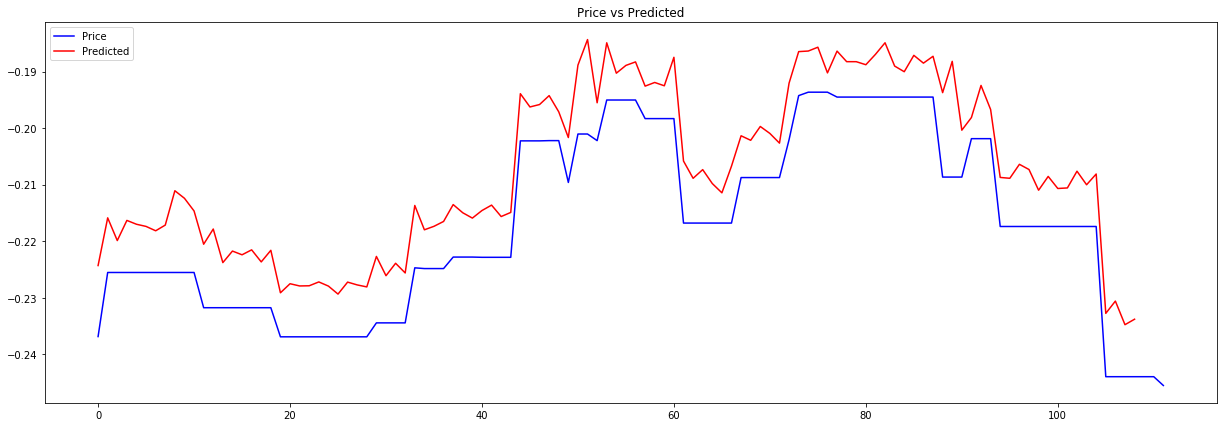

In [70]:
plt.figure(figsize=(21,7))
plt.plot(yTest,label='Price',color='blue')
plt.plot(test_pred_list,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()

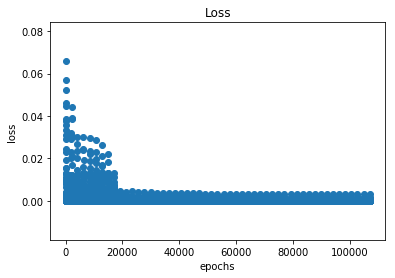

In [71]:
plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list)), y=loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### Now we split the data into disjoint time intervals

In [135]:
Train2 = dfNN.iloc[:4000, :]
Test2 = dfNN.iloc[4000:, :]
# Test2 = pd.DataFrame(Test2, columns = ['prev_price', 'compound', 'neg', 'neu','pos','next_price'])

print len(dfNN), len(Train2), dfNN.head(3), Test2.head(4)

xTrain2 = Train2[['prev_price','neu','neg','pos']].as_matrix()[::-1]
yTrain2 = Train2['next_price'].as_matrix()[::-1]


xTest2 = Test2[['prev_price','neu','neg','pos']].as_matrix()
yTest2 = Test2['next_price'].as_matrix()

6426 4000   prev_price  compound       neg       neu       pos next_price
0  -0.205992  0.342107 -0.041533 -0.237517   0.30568   0.468625
1   0.468625  -0.46241  0.214909  -0.11359 -0.110987   0.477325
2   0.477325  -0.16998  0.268896 -0.167578 -0.110987   0.475247      prev_price   compound        neg         neu        pos next_price
4010  -0.205992 -0.0718898  -0.041533    0.142851  -0.110987  -0.205992
4011  -0.205992  0.0914728 -0.0126986    0.031195 -0.0195893   -0.21097
4012   -0.21097  -0.317784   0.103866 -0.00254729  -0.110987   -0.21097
4013   -0.21097  -0.222427   0.129633   -0.380461   0.274766  -0.206425


In [142]:
loss_list = []
test_pred_list2 = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    num_epochs = 2
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            try:
                batchX = xTrain2[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
                batchY = yTrain2[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
            except:
                print xTrain2, start_idx, end_idx, batch_size, truncated_backprop_length, num_features
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
#             if type(loss) != float(1):
#                 print _loss,_train_step,_pred,_last_label,_prediction
            
           
            
            if(batch_idx % 50 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest2) - truncated_backprop_length):
        
        try:
            testBatchX = xTest2[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
            testBatchY = yTest2[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))
        except:
            pass
        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list2.append(test_pred[-1][0]) #The last one
        

Epoch 0
Step 0 - Loss: 0.135099
Step 50 - Loss: 0.004035
Step 100 - Loss: 0.000093
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.002927
Step 250 - Loss: 0.000265
Step 300 - Loss: 0.000330
Step 350 - Loss: 0.000925
Step 400 - Loss: 0.000367
Step 450 - Loss: 0.001888
Step 500 - Loss: 0.000125
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.003953
Step 650 - Loss: 0.000061
Step 700 - Loss: 0.002645
Step 750 - Loss: 0.000336
Step 800 - Loss: 0.000042
Step 850 - Loss: 0.000158
Step 900 - Loss: 0.000320
Step 950 - Loss: 0.000579
Step 1000 - Loss: 0.000160
Step 1050 - Loss: 0.000875
Step 1100 - Loss: 0.000128
Step 1150 - Loss: 0.000030
Step 1200 - Loss: 0.001807
Step 1250 - Loss: 0.019925
Step 1300 - Loss: 0.001796
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.477325060913

  0.3056795516845666]] 4161 4164 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.21490872839250844
  -0.11098711498210005]
 [-0.20599240077852973 -0.23751661931452944 -0.04153298939890261
  0.3056795516845666]] 4164 4167 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.214908728392508

  0.3056795516845666]] 4425 4428 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.21490872839250844
  -0.11098711498210005]
 [-0.20599240077852973 -0.23751661931452944 -0.04153298939890261
  0.3056795516845666]] 4428 4431 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.214908728392508

  0.3056795516845666]] 4806 4809 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.21490872839250844
  -0.11098711498210005]
 [-0.20599240077852973 -0.23751661931452944 -0.04153298939890261
  0.3056795516845666]] 4809 4812 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.214908728392508

  0.3056795516845666]] 5307 5310 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.21490872839250844
  -0.11098711498210005]
 [-0.20599240077852973 -0.23751661931452944 -0.04153298939890261
  0.3056795516845666]] 5310 5313 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.214908728392508

  0.3056795516845666]] 5808 5811 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.21490872839250844
  -0.11098711498210005]
 [-0.20599240077852973 -0.23751661931452944 -0.04153298939890261
  0.3056795516845666]] 5811 5814 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.214908728392508

  0.3056795516845666]] 6267 6270 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.21490872839250844
  -0.11098711498210005]
 [-0.20599240077852973 -0.23751661931452944 -0.04153298939890261
  0.3056795516845666]] 6270 6273 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.214908728392508

Step 350 - Loss: 0.000200
Step 400 - Loss: 0.000004
Step 450 - Loss: 0.000219
Step 500 - Loss: 0.000027
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000639
Step 650 - Loss: 0.000008
Step 700 - Loss: 0.000317
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000015
Step 850 - Loss: 0.000020
Step 900 - Loss: 0.000038
Step 950 - Loss: 0.000029
Step 1000 - Loss: 0.000094
Step 1050 - Loss: 0.000127
Step 1100 - Loss: 0.000004
Step 1150 - Loss: 0.000001
Step 1200 - Loss: 0.006781
Step 1250 - Loss: 0.010219
Step 1300 - Loss: 0.003267
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.21490872839250844
  -0.11098711498210005]
 [-0.20599240077852973 -0.23751

  0.3056795516845666]] 4089 4092 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.21490872839250844
  -0.11098711498210005]
 [-0.20599240077852973 -0.23751661931452944 -0.04153298939890261
  0.3056795516845666]] 4092 4095 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.214908728392508

  0.3056795516845666]] 4323 4326 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.21490872839250844
  -0.11098711498210005]
 [-0.20599240077852973 -0.23751661931452944 -0.04153298939890261
  0.3056795516845666]] 4326 4329 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.214908728392508

  0.3056795516845666]] 4623 4626 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.21490872839250844
  -0.11098711498210005]
 [-0.20599240077852973 -0.23751661931452944 -0.04153298939890261
  0.3056795516845666]] 4626 4629 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.214908728392508

  0.3056795516845666]] 5031 5034 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.21490872839250844
  -0.11098711498210005]
 [-0.20599240077852973 -0.23751661931452944 -0.04153298939890261
  0.3056795516845666]] 5034 5037 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.214908728392508

  0.3056795516845666]] 5574 5577 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.21490872839250844
  -0.11098711498210005]
 [-0.20599240077852973 -0.23751661931452944 -0.04153298939890261
  0.3056795516845666]] 5577 5580 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.214908728392508

  0.3056795516845666]] 6120 6123 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.21490872839250844
  -0.11098711498210005]
 [-0.20599240077852973 -0.23751661931452944 -0.04153298939890261
  0.3056795516845666]] 6123 6126 1 3 4
[[-0.21322121213685352 0.1152441168817897 -0.013925627435712429
  -0.11098711498210005]
 [-0.21322121213685352 -0.08352888925317968 -0.04153298939890261
  0.1369967559856419]
 [-0.20555953782294137 0.037330006452341705 -0.04153298939890261
  0.00460428286736231]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.214908728392508

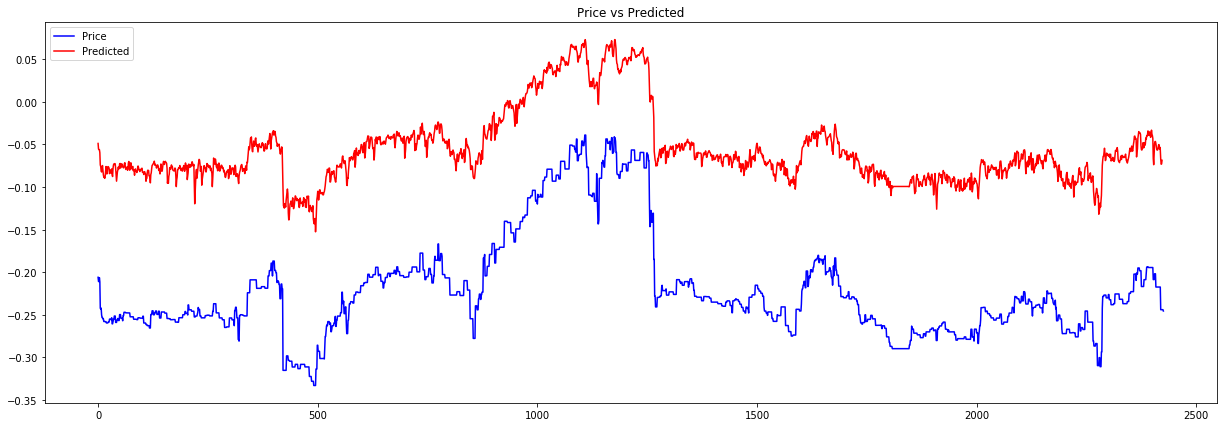

In [143]:
plt.figure(figsize=(21,7))
plt.plot(yTest2,label='Price',color='blue')
plt.plot(test_pred_list2,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()